In [24]:
from os import chdir
from glob import glob
import pandas as pd
import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

def mergeCSV(file_list):
    df_merge=pd.DataFrame()
    for file in file_list:
        df=pd.read_csv(file, header=None)
        df_merge=pd.concat([df, df_merge], ignore_index=True, sort=False)
    print(df_merge.shape)
    
    return df_merge


file_list=['C:/Users/antonebert/Desktop/WS2021 Programing/MADI/Activity Recognition from Single Chest-Mounted Accelerometer\\1.csv','C:/Users/antonebert/Desktop/WS2021 Programing/MADI/Activity Recognition from Single Chest-Mounted Accelerometer\\8.csv', 'C:/Users/antonebert/Desktop/WS2021 Programing/MADI/Activity Recognition from Single Chest-Mounted Accelerometer\\9.csv']

df_merged_csv=mergeCSV(file_list)


(467243, 5)


In [25]:
df = df_merged_csv
#df=df.drop('Sequence',axis=1)
df.head()

,0,1,2,3,4
0,0.0,2287,2948,2189,1
1,1.0,2249,2677,2046,1
2,2.0,2270,2568,2005,1
3,3.0,2222,2565,2003,1
4,4.0,2235,2571,2074,1


In [26]:
# Data Cleaning
df=df_merged_csv.drop(columns=[0])
df.columns=['x','y','z','label']
df_null=df[df["label"] == 0]
df_null.head()
print(df_null.shape)
df=df[df['label']>0]
df.shape

(3208, 4)


(464035, 4)

In [27]:
df.head()

,x,y,z,label
0,2287,2948,2189,1
1,2249,2677,2046,1
2,2270,2568,2005,1
3,2222,2565,2003,1
4,2235,2571,2074,1


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## Data are separated by participant
Each file contains the following information
sequential number, x acceleration, y acceleration, z acceleration, label
Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing


#### Class Distribution 

<AxesSubplot:xlabel='label', ylabel='count'>

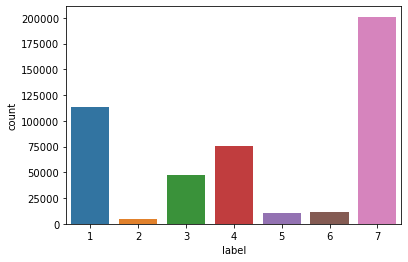

In [29]:
sns.countplot(x = 'label', data=df)

In [30]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
print(X.shape)

(464035, 3)


<bound method NDFrame.head of           x     y     z  label
0      2118  2525  2003      1
1      1970  2374  2120      1
2      1956  2383  2106      1
3      1862  2377  2075      1
4      1965  2372  2122      1
...     ...   ...   ...    ...
33126  2053  2533  2062      7
33127  1699  1859  1990      7
33128  1909  2388  1990      7
33129  1728  2231  1918      7
33130  2061  2545  2056      7

[33131 rows x 4 columns]>


<AxesSubplot:xlabel='label', ylabel='count'>

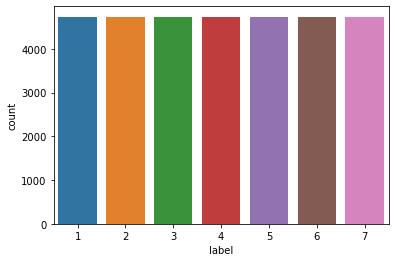

In [31]:
rus= RandomUnderSampler(random_state=0)
rus.fit(X,y)
X_resampled, y_resampled = rus.fit_sample(X,y)
df_resample = pd.concat([X_resampled,y_resampled], axis = 1)
print(df_resample.head)
sns.countplot(x = 'label', data=df_resample)

#### Encode Output
Pytorch supports labels from 0. [0,n]
- Dictionary class2idx , .replace method to change it, idx2class for reverse mapping

In [32]:
class2idx = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4,
    6:5,
    7:6
}

idx2class = {v: k for k, v in class2idx.items()}  # will be used later for reverse mapping

df_resample['label'].replace(class2idx, inplace=True)

In [33]:
df_resample.head(-5)
#df_resample.to_csv(r'C:\Users\antonebert\Desktop\WS2021 Programing\MADI\file.csv', index= None, header=True)

,x,y,z,label
0,2118,2525,2003,0
1,1970,2374,2120,0
2,1956,2383,2106,0
3,1862,2377,2075,0
4,1965,2372,2122,0
...,...,...,...,...
33121,1913,2383,1976,6
33122,1896,2381,2002,6
33123,2081,2537,2059,6
33124,2041,2544,2034,6


In [34]:
#Create input output data
X = df_resample.iloc[:, 0:-1]
y = df_resample.iloc[:, -1]

#### Stratification
Let’s assume you are doing a multiclass classification and have an imbalanced dataset that has 5 different classes. You do a simple train-test split that does a random split totally disregarding the distribution or proportions of the classes. What happens in this scenario is that you end up with a train and a test set with totally different data distributions. A model trained on a vastly different data distribution than the test set will perform inferiorly at validation. 
For more info: https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50

In [35]:
# Split into train+val (80%) and test(20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69) 

# Split train into train-val(train 72%, val 8%)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


#### fit: transform: fit_transform:

"fit" computes the mean and std to be used for later scaling. (just a computation), nothing is given to you. 
"transform" uses a previously computed mean and std to autoscale the data (subtract mean from all values and then divide it by std). 
"fit_transform" does both at the same time.

#### Note:
We use .fit_transform() on X_train while we use .transform() on X_val and X_test.
We do this because we want to scale the validation and test set with the same parameters as that of the train set to avoid data leakage.


In [36]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) #mean and std used later to autoscale
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

## Neural Network

In [37]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [38]:
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.07
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 7

#### Dataloader

In [39]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

#### Define Neural Net Architechture

In [40]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [42]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=3, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


#### Train Model

In [43]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [44]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [45]:
print("Training....")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Training....


Epoch 001: | Train Loss: 1.86214 | Val Loss: 1.74592 | Train Acc: 3.018| Val Acc: 22.935
Epoch 002: | Train Loss: 1.82208 | Val Loss: 1.69691 | Train Acc: 3.689| Val Acc: 30.479
Epoch 003: | Train Loss: 1.80756 | Val Loss: 1.72148 | Train Acc: 3.320| Val Acc: 31.045
Epoch 004: | Train Loss: 1.80072 | Val Loss: 1.62553 | Train Acc: 3.555| Val Acc: 31.309
Epoch 005: | Train Loss: 1.79894 | Val Loss: 1.68547 | Train Acc: 3.756| Val Acc: 30.177
Epoch 006: | Train Loss: 1.79081 | Val Loss: 1.64488 | Train Acc: 3.689| Val Acc: 31.271
Epoch 007: | Train Loss: 1.78814 | Val Loss: 1.67323 | Train Acc: 4.091| Val Acc: 31.611
Epoch 008: | Train Loss: 1.78329 | Val Loss: 1.66967 | Train Acc: 4.125| Val Acc: 32.667
Epoch 009: | Train Loss: 1.78304 | Val Loss: 1.69037 | Train Acc: 3.353| Val Acc: 32.667
Epoch 010: | Train Loss: 1.77926 | Val Loss: 1.66247 | Train Acc: 3.856| Val Acc: 32.629



Text(0.5, 1.0, 'Train-Val Loss/Epoch')

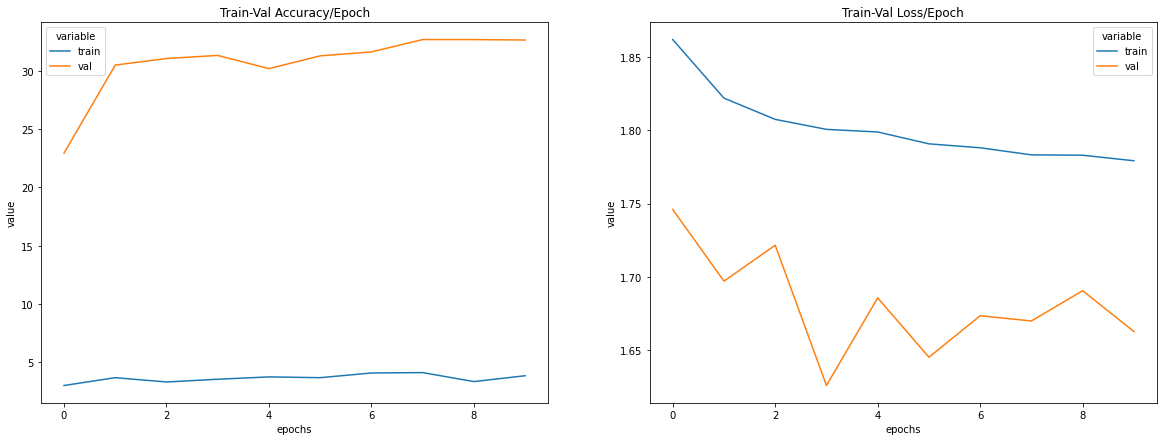

In [46]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [47]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [48]:
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
confusion_matrix=(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])
print(np.round(confusion_matrix,2))


      1     2     3     4     5    6    7
1  0.65  0.33  0.00  0.01  0.00  0.0  0.0
2  0.16  0.79  0.00  0.04  0.01  0.0  0.0
3  0.15  0.09  0.00  0.35  0.42  0.0  0.0
4  0.24  0.07  0.00  0.51  0.18  0.0  0.0
5  0.20  0.02  0.00  0.40  0.38  0.0  0.0
6  0.07  0.03  0.00  0.31  0.59  0.0  0.0
7  0.11  0.05  0.02  0.50  0.31  0.0  0.0


C:\Users\antonebert\anaconda3\envs\madi4\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


ValueError: can only convert an array of size 1 to a Python scalar

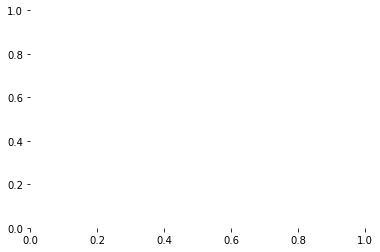

In [49]:
vmin = np.min(confusion_matrix)
vmax = np.max(confusion_matrix)
off_diag_mask = np.eye(*confusion_matrix.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(confusion_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
sns.heatmap(confusion_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

In [ ]:
fig = plt.figure()
gs0 = matplotlib.gridspec.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

sns.heatmap(confusion_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax2)
sns.heatmap(confusion_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[]))

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
print(confusion_matrix_df)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))

0: Working at Computer

1: x Standing Up, Walking and Going updown stairs x

2: Standing

3: Walking

4: x Going UpDown Stairs x

5: x Walking and Talking with Someone x

6: Talking while Standing

Data are separated by participant
Each file contains the following information sequential number, x acceleration, y acceleration, z acceleration, label Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing

              precision    recall  f1-score   support

           1       1.00      0.97      0.98      6735
           2       0.00      0.00      0.00       186
           3       0.51      0.60      0.55      2236
           4       0.81      0.97      0.88      5372
           5       0.62      0.64      0.63       638
           6       0.32      0.50      0.39       583
           7       1.00      0.91      0.96     16750

    accuracy                           0.89     32500
   macro avg       0.61      0.66      0.63     32500
weighted avg       0.91      0.89      0.90     32500